
# Сегментация потребителей леденцов

Цель исследования — выделить интерпретируемые сегменты потребителей леденцов на основании их мотивов потребления. Мы рассмотрим методы k-means и иерархической кластеризации, подберём число кластеров методом локтя и интерпретируем полученные группы.



## Описание набора данных

Каждый из 338 респондентов оценил по шкале от 1 до 5 степень согласия с 11 высказываниями:

- **V1** — потребляю леденцы, чтобы освежить дыхание.
- **V2** — потребляю леденцы, чтобы чувствовать себя увереннее.
- **V3** — потребляю леденцы, чтобы освежить полость рта.
- **V4** — потребляю леденцы, чтобы избавиться от неприятного вкуса во рту.
- **V5** — потребляю леденцы как заменитель других кондитерских изделий.
- **V6** — потребляю леденцы, когда хочется чего-нибудь сладкого.
- **V7** — леденцы помогают сконцентрироваться.
- **V8** — потребляю леденцы, чтобы отвлечься и подумать.
- **V9** — потребляю леденцы, чтобы облегчить боль в горле.
- **V10** — потребляю леденцы, чтобы избавиться от заложенности носа.
- **V11** — потребляю леденцы для улучшения самочувствия.


In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:
data_path = Path("Леденцы.dat")
if not data_path.exists():
    data_path = Path("Кластеризация") / "Леденцы.dat"

df = pd.read_csv(data_path, sep=";")
print(f"Размерность: {df.shape[0]} наблюдений × {df.shape[1]} признаков")
display(df.head())


Размерность: 338 наблюдений × 11 признаков


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
0,4,5,5,5,3,3,3,3,3,3,3
1,5,4,5,5,3,3,3,3,3,3,3
2,5,5,4,5,3,3,3,3,3,3,3
3,5,4,5,5,3,3,3,3,3,3,3
4,4,5,5,5,3,3,3,3,3,3,3


In [3]:

display(df.describe().T.round(2))


,count,mean,std,min,25%,50%,75%,max
V1,338.0,3.54,0.96,2.0,3.0,3.0,5.0,5.0
V2,338.0,3.53,0.96,2.0,3.0,3.0,5.0,5.0
V3,338.0,3.52,0.99,2.0,3.0,3.0,5.0,5.0
V4,338.0,3.41,0.99,2.0,3.0,3.0,4.0,5.0
V5,338.0,3.21,0.87,2.0,3.0,3.0,3.0,5.0
V6,338.0,3.20,0.87,2.0,3.0,3.0,3.0,5.0
V7,338.0,3.25,0.84,2.0,3.0,3.0,3.0,5.0
V8,338.0,3.29,0.82,2.0,3.0,3.0,3.0,5.0
V9,338.0,3.60,0.97,2.0,3.0,3.0,5.0,5.0
V10,338.0,3.55,0.93,2.0,3.0,3.0,5.0,5.0



### Подготовка данных

Перед кластеризацией приведём признаки к одной шкале: стандартизируем их так, чтобы каждый показатель имел нулевое среднее и единичное стандартное отклонение.


In [4]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)



## Подбор числа кластеров: метод локтя

Используем метод локтя и силуэт для диапазона k от 2 до 8. Точка перегиба на графике инерции и максимум силуэта подскажут подходящее число кластеров.


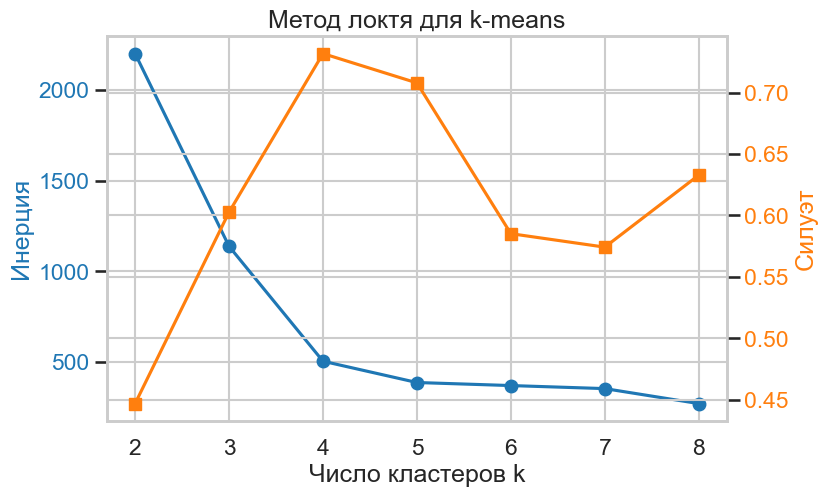

,inertia,silhouette
k,,
2,2199.67,0.447
3,1137.78,0.603
4,504.73,0.732
5,387.44,0.708
6,370.64,0.585
7,353.88,0.574
8,271.36,0.633


In [5]:

k_range = range(2, 9)

inertias = []
silhouettes = []

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels_test = kmeans_test.fit_predict(X_scaled)
    inertias.append(kmeans_test.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels_test))

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(list(k_range), inertias, marker="o", color="#1f77b4")
ax1.set_xlabel("Число кластеров k")
ax1.set_ylabel("Инерция", color="#1f77b4")
ax1.tick_params(axis="y", labelcolor="#1f77b4")
ax1.set_title("Метод локтя для k-means")

ax2 = ax1.twinx()
ax2.plot(list(k_range), silhouettes, marker="s", color="#ff7f0e")
ax2.set_ylabel("Силуэт", color="#ff7f0e")
ax2.tick_params(axis="y", labelcolor="#ff7f0e")

plt.show()

summary_metrics = (
    pd.DataFrame({"k": list(k_range), "inertia": inertias, "silhouette": silhouettes})
    .set_index("k")
    .round({"inertia": 2, "silhouette": 3})
)
display(summary_metrics)



График демонстрирует ярко выраженный перегиб при **k = 4**: после четырёх кластеров инерция уменьшается значительно медленнее. Дополнительно силуэт достигает максимума (0.732) также при k = 4, что подтверждает выбор — сегменты получаются наиболее компактными и хорошо разделёнными.



## Кластеризация методом k-means

Обучим модель k-means с четырьмя кластерами, оценим метрику силуэта, размеры групп и средние значения признаков.


In [6]:

k_opt = 4
kmeans = KMeans(n_clusters=k_opt, n_init="auto", random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
print(f"Силуэт k-means: {silhouette_kmeans:.3f}")

kmeans_counts = pd.Series(kmeans_labels).value_counts().sort_index()
display(pd.DataFrame({"cluster": kmeans_counts.index, "size": kmeans_counts.values}))

kmeans_profile = (
    df.assign(cluster=kmeans_labels)
      .groupby("cluster")
      .mean()
      .round(2)
)
display(kmeans_profile)


Силуэт k-means: 0.732


,cluster,size
0,0,108
1,1,61
2,2,110
3,3,59


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
cluster,,,,,,,,,,,
0,2.82,2.83,2.77,2.62,2.61,2.58,2.75,2.92,4.95,4.81,4.86
1,3.00,3.00,3.00,3.00,4.85,4.85,3.00,2.92,2.75,2.75,2.75
2,4.85,4.80,4.84,4.68,3.04,3.04,3.00,2.99,3.07,3.05,3.05
3,3.00,2.97,2.97,2.92,2.92,2.95,4.92,4.92,3.00,3.00,3.00



### Интерпретация сегментов (k-means)

- **Кластер 0 (108 респондентов)** — высокие оценки по мотивам облегчения боли в горле и устранения простудных симптомов (V9–V11). Это «лечебный» сегмент, использующий леденцы как средство от недомоганий.
- **Кластер 1 (61 респондент)** — выраженный интерес к замене других сладостей (V5–V6). Сегмент «замена десертов», воспринимающий леденцы как альтернативу сладкому.
- **Кластер 2 (110 респондентов)** — максимальные оценки по мотивам свежести дыхания и уверенности (V1–V4), при среднем отношении к другим причинам. Это сегмент «свежесть и уверенность».
- **Кластер 3 (59 респондентов)** — высокие значения по концентрации и переключению внимания (V7–V8). «Фокус и перерыв»: леденцы помогают сосредоточиться и сделать паузу.

Сегменты сбалансированы по размеру и легко интерпретируются маркетологами.



### Визуализация сегментов

Для наглядности снизим размерность признаков до двух главных компонент (PCA) и посмотрим, как располагаются респонденты каждого кластера.


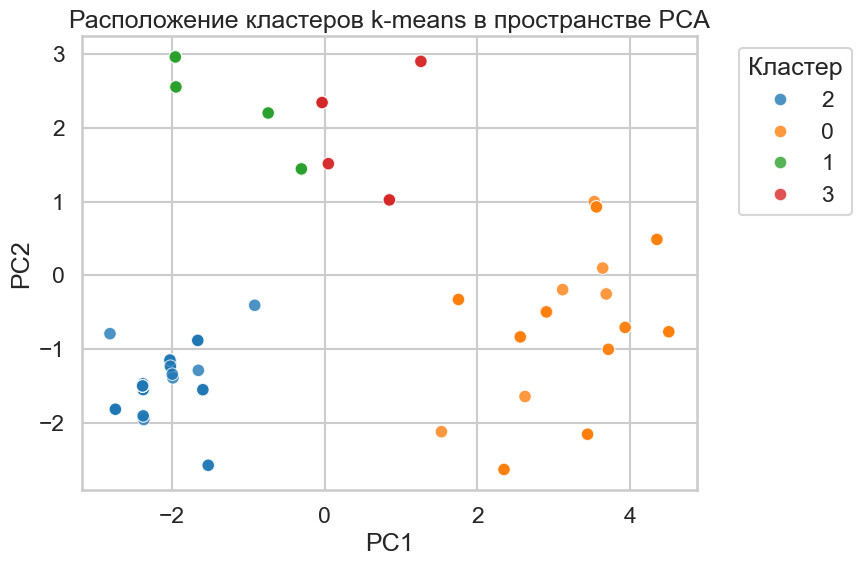

In [7]:

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame({
    "PC1": components[:, 0],
    "PC2": components[:, 1],
    "cluster": kmeans_labels.astype(str)
})

plt.figure(figsize=(9, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.8)
plt.title("Расположение кластеров k-means в пространстве PCA")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



## Иерархическая кластеризация

Применим агломеративную кластеризацию с критерием Уорда (Ward) для тех же четырёх сегментов и сравним профили.


In [8]:

agg = AgglomerativeClustering(n_clusters=k_opt, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)

agg_counts = pd.Series(agg_labels).value_counts().sort_index()
display(pd.DataFrame({"cluster": agg_counts.index, "size": agg_counts.values}))

agg_profile = (
    df.assign(cluster=agg_labels)
      .groupby("cluster")
      .mean()
      .round(2)
)
display(agg_profile)

comparison = pd.crosstab(kmeans_labels, agg_labels, rownames=["k-means"], colnames=["Agglomerative"])
display(comparison)


,cluster,size
0,0,108
1,1,61
2,2,110
3,3,59


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
cluster,,,,,,,,,,,
0,2.82,2.83,2.77,2.62,2.61,2.58,2.75,2.92,4.95,4.81,4.86
1,3.00,3.00,3.00,3.00,4.85,4.85,3.00,2.92,2.75,2.75,2.75
2,4.85,4.80,4.84,4.68,3.04,3.04,3.00,2.99,3.07,3.05,3.05
3,3.00,2.97,2.97,2.92,2.92,2.95,4.92,4.92,3.00,3.00,3.00


Agglomerative,0,1,2,3
k-means,,,,
0,108,0,0,0
1,0,61,0,0
2,0,0,110,0
3,0,0,0,59



Агломеративная кластеризация воспроизводит те же четыре сегмента (матрица сопряжённости близка к диагональной). Это подтверждает устойчивость выявленных групп и удобство их интерпретации вне зависимости от алгоритма.



## Выводы и рекомендации

- Оптимальное число сегментов — **4** (перегиб инерции и максимум силуэта).
- Оба алгоритма формируют сопоставимые группы, что повышает доверие к сегментации.
- Интерпретация сегментов:
  1. «Лечебные» — используют леденцы как средство от боли в горле и простуды.
  2. «Сладкоежки» — рассматривают леденцы как заменитель других десертов.
  3. «Свежесть и уверенность» — ценят свежесть дыхания и уверенность в себе.
  4. «Фокус и перерыв» — применяют леденцы для концентрации и короткой паузы.

Для маркетинга: можно нацеливать коммуникации и промо-акции, подчёркивая ключевой мотив каждого сегмента; рассмотреть адаптацию продукта (например, линейка с функциональными ингредиентами для «лечебных» и более яркие вкусы для «сладкоежек»).
